In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#library for Anomaly Detection
from sklearn.neighbors import LocalOutlierFactor

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading data from cpu_utilization csv file, making date as index

cpu_df = pd.read_csv('ec2_cpu_utilization_24ae8d.csv', parse_dates = ['timestamp'], index_col = ['timestamp'])
cpu_df['value'] = cpu_df['value'].astype(float)
cpu_df.index = pd.to_datetime(cpu_df.index)

In [3]:
display(cpu_df)

,value
timestamp,
2014-02-14 14:30:00,0.132
2014-02-14 14:35:00,0.134
2014-02-14 14:40:00,0.134
2014-02-14 14:45:00,0.134
2014-02-14 14:50:00,0.134
...,...
2014-02-28 14:05:00,0.132
2014-02-28 14:10:00,0.134
2014-02-28 14:15:00,0.134


The value column in above dataset has AWS server metrics as collected by the AmazonCloudwatch service,it includes CPU Utilization every 5 mins.

In [4]:
display(cpu_df.describe())

,value
count,4032.000000
mean,0.126303
std,0.094813
min,0.066000
25%,0.132000
50%,0.134000
75%,0.134000
max,2.344000


In [5]:
display(cpu_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4032 entries, 2014-02-14 14:30:00 to 2014-02-28 14:25:00
Data columns (total 1 columns):
value    4032 non-null float64
dtypes: float64(1)
memory usage: 63.0 KB


None

I will build a scatterplot that will allow me to visualize the data and help me find the anomalies,if any.

Text(0.5, 1.0, 'AWS Cloudwatch CPU Utilization')

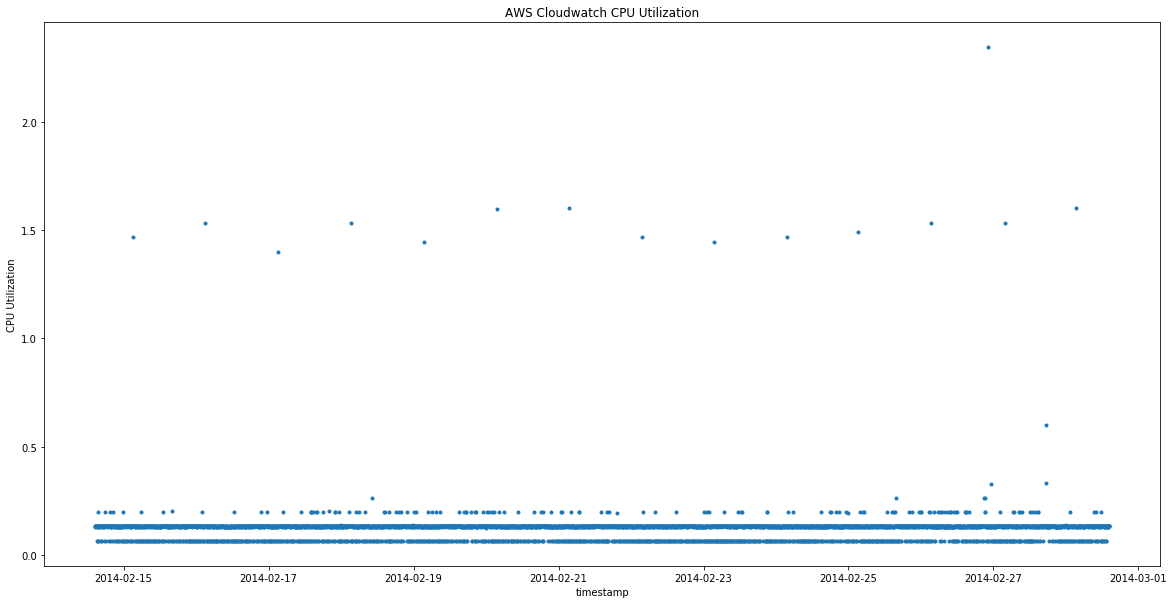

In [6]:
#plotting graph to visualize the data
plt.figure(figsize=(20,10))
plt.xlabel('timestamp')
plt.ylabel('CPU Utilization')
plt.plot_date(cpu_df.index, cpu_df.value, markersize=3)
plt.title('AWS Cloudwatch CPU Utilization')

We can already see some points that seem to be the outliers. For example after 2014-02-15 there is a value close to 1.5. There are a couple of points around 1.5 which can be treated as anomalies.

However, this graph has too much data, it would be better to see the trend if we can group the values by the hour and average them.

In [7]:
#function for Identifying outliers
def detect_outlier(data_1):
    outliers_dates=[]
    outliers=[]
    threshold=3
    
    mean_1 = np.mean(data_1.value)
    std_1 =np.std(data_1.value)
    
    for x, y in zip(data_1.index, data_1.value):
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers_dates.append(x)
            outliers.append(y)
            
    return outliers_dates, outliers

The above function is for identifying the outliers in the dataset.

---
I'm going to group the cpu-utilization dataset hourwise so the trend will be clearer.
After that I'll find the outliers from the new dataset and plot the scatter-graph to visualize the anomalies.


In [8]:
cpu_df = cpu_df.groupby(pd.Grouper(freq='H')).mean()

display(cpu_df)

,value
timestamp,
2014-02-14 14:00:00,0.133667
2014-02-14 15:00:00,0.122333
2014-02-14 16:00:00,0.122667
2014-02-14 17:00:00,0.133667
2014-02-14 18:00:00,0.128333
...,...
2014-02-28 10:00:00,0.117500
2014-02-28 11:00:00,0.128167
2014-02-28 12:00:00,0.116833


I'm going to apply 'Skyline Anomaly Detection' on this dataset because it is an algorithm which can be used to automatically find out what it means for each metric to be anomalous. Once set up and running, Skyline allows the user to train it what is not anomalous on a per metric basis.

Text(0.5, 1.0, 'Skyline Anomaly Detection on \nAWS Cloudwatch CPU Utilization')

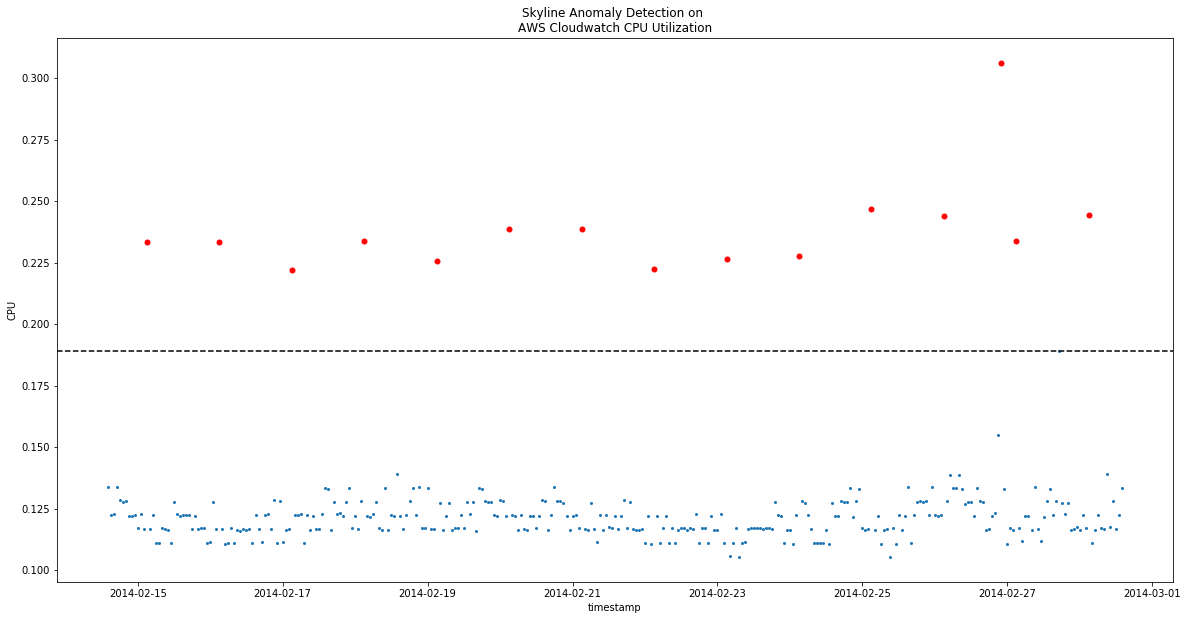

In [9]:
'''
Skyline Anomaly Detection
'''

#Identifying outliers in the dataframe
out_lier_date , out_lier = detect_outlier(cpu_df)

min_outlier = min(out_lier)
sorted_value = sorted(cpu_df.value)

#getting predecessor of minimum outlier value
p=0
for v in sorted_value:
    if v==min_outlier:
        break
    else:
        p=v   

#plotting graph
plt.figure(figsize=(20,10))
plt.xlabel('timestamp')
plt.ylabel('CPU')
#plotting values
plt.plot_date(cpu_df.index, cpu_df.value, markersize=2)
#plotting outliers
plt.plot_date(out_lier_date, out_lier, c='red', markersize=5)
plt.axhline(p, color='black', linestyle='--')
plt.title('Skyline Anomaly Detection on \nAWS Cloudwatch CPU Utilization')

We can see that there are some anomalies(red dots) in the new dataset.

The black horizontal line shows detected anomalous datapoints.

This anomaly detection is useful to find out the threshold of a data for example if the cpu utilzation is going beyond the Anomalous datapoint line, it can provide a message or warning.

---
Now, I'm going to apply Local-outlier Factor on the another dataset i.e Amazon EC2 Network reading bytes. Local Outlier Factor compares local density to density of neighbors which is helpful to identify loosely connected data points which are more likely to be outliers.

In [10]:
'''
Local-Outlier Factor
'''
#reading Network Bytes In data from csv file, making date as index

net_df = pd.read_csv('ec2_network_in_5abac7.csv', parse_dates = ['timestamp'], index_col = ['timestamp'])
net_df['value'] = net_df['value'].astype(float)
net_df.index = pd.to_datetime(net_df.index)

#Dropping zero values
net_df = net_df[(net_df.T != 0).any()]


In [11]:
display(net_df)

,value
timestamp,
2014-03-01 17:36:00,42.0
2014-03-01 17:41:00,94.8
2014-03-01 17:46:00,42.0
2014-03-01 17:51:00,68.4
2014-03-01 17:56:00,68.4
...,...
2014-03-18 03:21:00,42.0
2014-03-18 03:26:00,42.0
2014-03-18 03:31:00,118.5


The value column in above dataset has AWS network server metrics as collected by the AmazonCloudwatch service, it records Network reading bytes every 5 mins.

In [12]:
display(net_df.describe())

,value
count,4.730000e+03
mean,1.187146e+05
std,7.757187e+05
min,4.200000e+01
25%,4.200000e+01
50%,6.840000e+01
75%,1.080000e+02
max,8.285420e+06


In [13]:
display(net_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4730 entries, 2014-03-01 17:36:00 to 2014-03-18 03:41:00
Data columns (total 1 columns):
value    4730 non-null float64
dtypes: float64(1)
memory usage: 73.9 KB


None

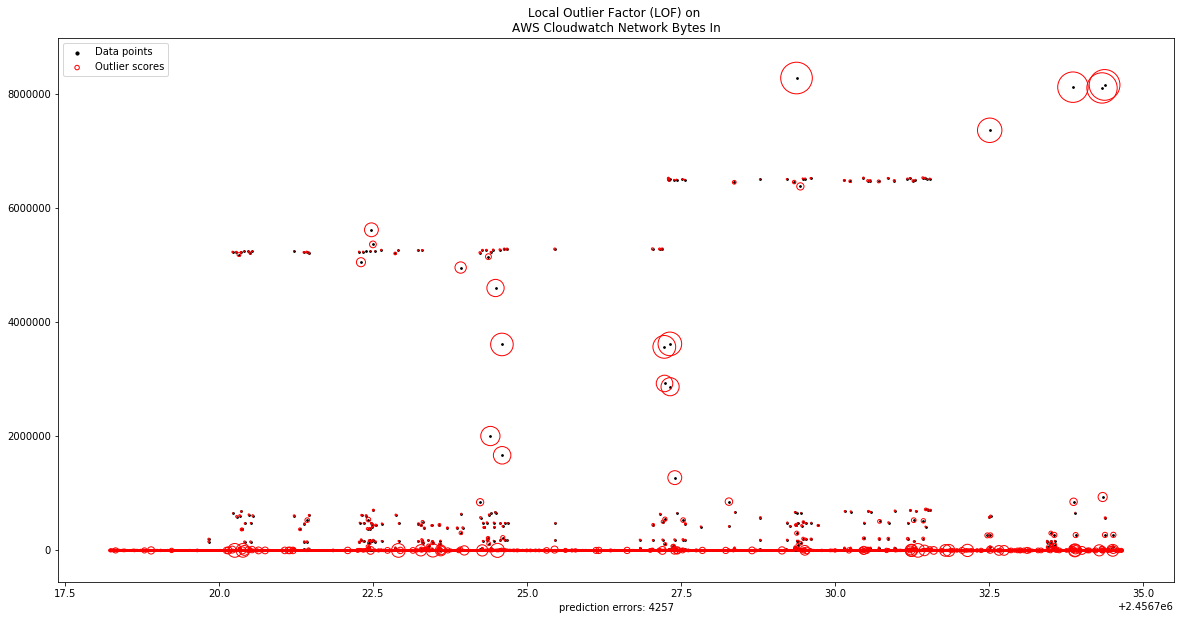

In [14]:
#creating dataset by merging dates with value column-wise
X = np.c_[net_df.index.to_julian_date(), net_df.value]

n_outliers = len(net_df.value)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)

n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.figure(figsize=(20,10))
plt.title("Local Outlier Factor (LOF) on \nAWS Cloudwatch Network Bytes In")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

The LOF algorithm is an unsupervised anomaly detection method.

It computes the local density deviation of a given data point with respect to its neighbors which are mostly residing around zero(0) in the above graph and it considers as outliers the samples that have a substantially lower density than their neighbors which are mostly  residing above zero as we can see in the above graph.
 
---
Now, I'm going to apply another method 'IsolationForest' on the another dataset i.e Amazon EC2 Disk writes bytes.

It uses multiple decision trees with random number of features used for splitting such that the Outliers will have short path lengths

In [15]:
'''
IsolationForest
'''
#reading Disk Read Bytes data from csv file, making date as index

disk_df = pd.read_csv('ec2_disk_write_bytes_c0d644.csv', parse_dates = ['timestamp'], index_col = ['timestamp'])
disk_df['value'] = disk_df['value'].astype(float)
disk_df.index = pd.to_datetime(disk_df.index)

disk_df = disk_df[(disk_df.T != 0).any()]


In [16]:
display(disk_df)

,value
timestamp,
2014-04-02 15:00:00,19949200.0
2014-04-02 15:05:00,48951300.0
2014-04-02 15:10:00,431199000.0
2014-04-02 15:15:00,36434700.0
2014-04-02 15:20:00,1558940.0
...,...
2014-04-16 10:15:00,2232320.0
2014-04-16 11:15:00,12288.0
2014-04-16 12:15:00,1885800.0


The value column in above dataset has AWS EC2 metrics as collected by the AmazonCloudwatch service, records Disk Read bytes every 5 mins.

In [17]:
display(disk_df.describe())

,value
count,7.760000e+02
mean,9.005115e+07
std,1.627247e+08
min,8.192000e+02
25%,9.330688e+05
50%,8.313240e+06
75%,1.031618e+08
max,8.639640e+08


In [18]:
display(disk_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 776 entries, 2014-04-02 15:00:00 to 2014-04-16 13:20:00
Data columns (total 1 columns):
value    776 non-null float64
dtypes: float64(1)
memory usage: 12.1 KB


None

Text(0.5, 1.0, 'Isolation Forest on\nAWS Cloudwatch Disk Read Bytes')

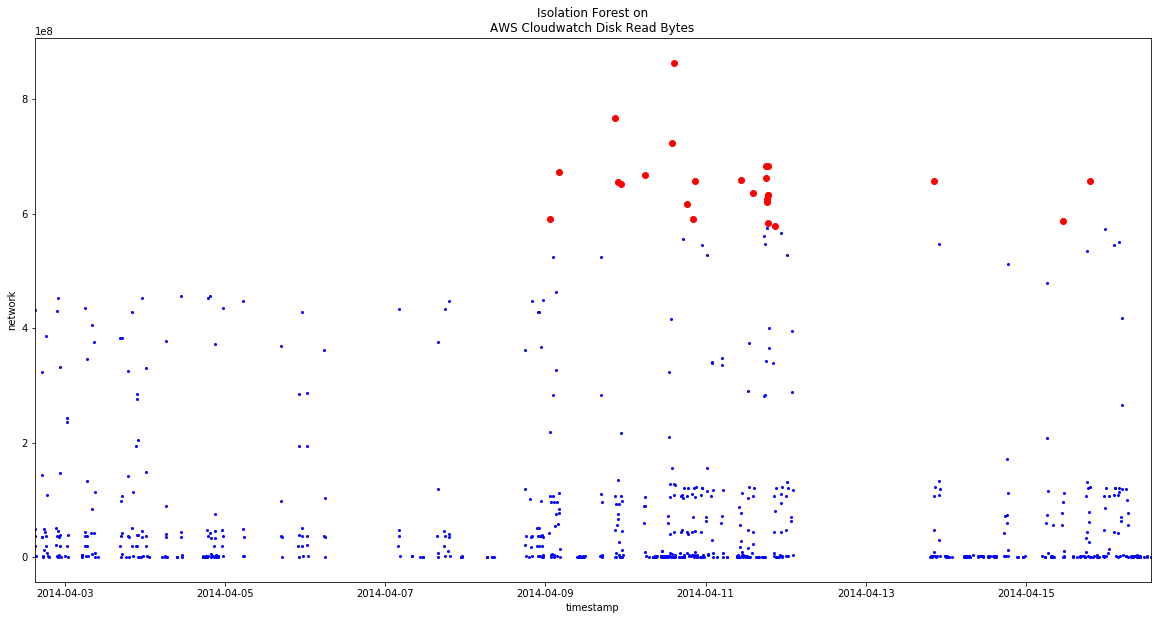

In [19]:
#Identifying outliers in the dataframe
out_lier_date , out_lier = detect_outlier(disk_df)

plt.figure(figsize=(20,10))
plt.plot_date(disk_df.index, disk_df.value,color='blue', markersize=2)

plt.plot_date(out_lier_date , out_lier,color='red')
plt.xlim(disk_df.index[0], disk_df.index[-1])

plt.xlabel('timestamp')
plt.ylabel('network')
plt.title('Isolation Forest on\nAWS Cloudwatch Disk Read Bytes')

Now  we can clearly see the anomalies in the above graph using IsolationForest.

### Summary:
---
* Reading diffrent CSVs for applying different Anomaly Detection method.
* First we took the CPU utilization data, made date its index.
* Simply Plotted a graph to visualize the data.
* Then I've grouped the data hour-wise so the trend will be clearer. 
* After that I've found out the outliers from the new dataset.
* Applied Skyline Anomaly Detection on CPU utilization and plotted the scatter-grpah to visualize the anomalies.
* Again read Network Bytes data from another CSV, and again made date its index.
* Applied Local-Outlier Factor from sklearn library on Network Bytes data and plotted the scatter-graph.
* After that, I've read Disk Read Bytes data from another CSV, amd for that too, made date its index.
* And finally, Applied IsolationForest Anomaly Detection on Disk Read Bytes data and plotted the final graph.